In [1]:
import cv2
import numpy as np
import requests
from PIL import Image
import dlib

In [2]:
# This function gets the first index from a numpy array. It's used to locate specific points in the image.
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:  # Loop through the array to find the first number
        index = num
        break
    return index

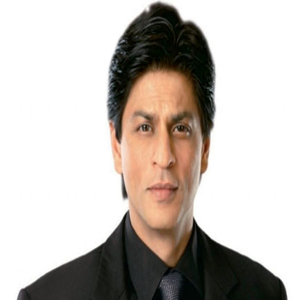

In [3]:
# Read and resize the first image (source face)
img1 = Image.open('/content/drive/MyDrive/FACE SWAP APP FILES/try5.jpg')
img1 = img1.resize((300, 300))  # Resize for consistent processing
img1

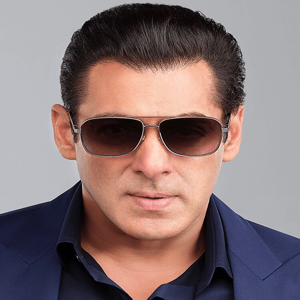

In [4]:
# Read and resize the second image (target face)
img2 = Image.open('/content/drive/MyDrive/FACE SWAP APP FILES/try6.jpg')
img2 = img2.resize((300, 300))  # Resize for consistent processing
img2

In [5]:
# Convert the images to numpy arrays (required for OpenCV processing)
ig1 = np.array(img1)
ig1_gray = cv2.cvtColor(ig1, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for facial detection
mask = np.zeros_like(ig1_gray)  # Create a blank mask for the source face
ig2 = np.array(img2)
ig2_gray = cv2.cvtColor(ig2, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for facial detection

In [6]:
# Load the face detector and landmark predictor from dlib
detect = dlib.get_frontal_face_detector()
predict = dlib.shape_predictor('/content/drive/MyDrive/FACE SWAP APP FILES/shape_predictor_68_face_landmarks.dat')

# Prepare a blank canvas for the swapped face
hgt, wth, chnl = ig2.shape
im2_new_face = np.zeros((hgt, wth, chnl), np.uint8)

In [7]:
# Detect the face in the first (source) image and get landmarks
face1 = detect(ig1_gray)
for face in face1:
    landmarks = predict(ig1_gray, face)  # Get 68 facial landmarks
    landmarks_points = []
    for n in range(0, 68):  # Loop through each landmark point
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    # Create a convex hull (outline) of the face using landmarks
    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)  # Create a mask of the face

    # Crop the face from the source image using the mask
    face_image_1 = cv2.bitwise_and(ig1, ig1, mask=mask)

    # Divide the face into triangles for precise warping
    rect = cv2.boundingRect(convexhull)  # Find the bounding box around the face
    subdiv = cv2.Subdiv2D(rect)  # Create a subdivision of the bounding box
    subdiv.insert(landmarks_points)  # Insert the face landmarks into the subdivision
    triangles = subdiv.getTriangleList()  # Get the list of triangles
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []  # Store the triangle vertex indexes

    # Map each triangle to its points
    for triangle in triangles:
        pt1 = (triangle[0], triangle[1])
        pt2 = (triangle[2], triangle[3])
        pt3 = (triangle[4], triangle[5])

        # Find the indexes of each triangle vertex
        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        # Only add triangles where all points are valid
        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

In [8]:
# Detect the face in the second (target) image and get landmarks
face2 = detect(ig2_gray)
for face in face2:
    landmarks = predict(ig2_gray, face)  # Get 68 facial landmarks
    landmarks_points2 = []
    for i in range(0, 68):  # Loop through each landmark point
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        landmarks_points2.append((x, y))

    # Create a convex hull (outline) of the face using landmarks
    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

In [9]:
# Warp and transfer triangles from the source face to the target face
lines_space_mask = np.zeros_like(ig1_gray)  # For drawing triangles
lines_space_new_face = np.zeros_like(ig2)  # For the new face image

In [10]:
for triangle_index in indexes_triangles:
    # Get the three points of the current triangle from the source face (landmarks)
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)  # Form the triangle as an array

    # Get the rectangle that bounds the triangle (to process only this small area)
    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1  # Extract rectangle's x, y position and width, height

    # Crop the triangle region from the source image
    cropped_triangle = ig1[y:y+h, x:x+w]

    # Create a blank mask for the triangle area in the source face
    cropped_tr1_mask = np.zeros((h, w), np.uint8)

    # Adjust the triangle points relative to the cropped rectangle
    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    # Fill the mask with the triangle shape
    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Draw the triangle on the lines space mask for visualization
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)

    # Apply the mask to extract the triangle from the source face
    lines_space = cv2.bitwise_and(ig1, ig1, mask=lines_space_mask)

    # Get the corresponding points of the triangle in the target face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    t2_pt2 = landmarks_points2[triangle_index[1]]
    t2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, t2_pt2, t2_pt3], np.int32)

    # Get the rectangle that bounds the target triangle
    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    # Create a blank mask for the target triangle
    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    # Adjust the target triangle points relative to the cropped rectangle
    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [t2_pt2[0] - x, t2_pt2[1] - y],
                        [t2_pt3[0] - x, t2_pt3[1] - y]], np.int32)

    # Fill the mask with the target triangle shape
    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Convert points to float for affine transformation
    points = np.float32(points)
    points2 = np.float32(points2)

    # Get the affine transform matrix and warp the triangle from source to target
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Get the area in the target face where the warped triangle will be added
    img2_new_face_rect_area = im2_new_face[y:y+h, x:x+w]

    # Convert the area to grayscale to prepare for blending
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)

    # Remove any existing content in the triangle area and blend the new triangle
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)
    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    im2_new_face[y:y+h, x:x+w] = img2_new_face_rect_area  # Place the updated area back into the target face

In [11]:
# Create a mask for the entire face in the target image
img2_face_mask = np.zeros_like(ig2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)  # Fill the face area
img2_face_mask = cv2.bitwise_not(img2_head_mask)  # Invert the mask to get the non-face area

In [12]:
# Remove the face region from the target image
img2_head_noface = cv2.bitwise_and(ig2, ig2, mask=img2_face_mask)

# Add the new face to the target image
result2 = cv2.add(img2_head_noface, im2_new_face)

In [13]:
# Blend the new face seamlessly into the target image
(x, y, w, h) = cv2.boundingRect(convexhull2)  # Get the bounding box for the face
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))  # Calculate the center of the face
seamlessClone = cv2.seamlessClone(result2, ig2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

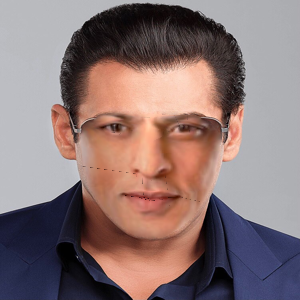

In [14]:
# Display the final image
Image.fromarray(seamlessClone)